![](https://img.shields.io/badge/CNES_AVISO-Contribution-%20?color=grey&labelColor=blue)

# SWOT L2 KaRIn LR Ocean Data Products

This tutorial will introduce you to some sample SWOT L2 KaRIn LR data products and show you how to download these data from AVISO and perform basic plots using Python related libraries.

## Tutorial Objectives
- Present SWOT sample L2 KaRIn LR data products (Basic version)
- Show you how to find and visualize SWOT Sea Level Anomaly (SLA) data sets from AVISO FTP server
- Download SWOT KaRIn (2D swaths) data

## Import + code



In [25]:
# Install Cartopy with mamba to avoid discrepancies
# ! mamba install -q -c conda-forge cartopy

In [1]:
import requests
import numpy as np
import xarray as xr

import os
import ftplib
from getpass import getpass
import cartopy.crs as ccrs
import cartopy.feature as cft
import cartopy.mpl.geoaxes as cmplgeo
import cartopy.mpl.gridliner as cmplgrid
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
def ftp_data_access(ftp_path, filename, username=None, password=None, local_filepath=None):
    # Set up FTP server details
    ftpAVISO = 'ftp-access.aviso.altimetry.fr'
    
    try:
        # Prompt for username and password
        if not username:
            username = input("Enter username for AVISO: ")
        if not password:
            password = getpass(prompt=f"Enter password for {username}: ")

        # Logging into FTP server using provided credentials
        with ftplib.FTP(ftpAVISO) as ftp:
            ftp.login(username, password)
            ftp.cwd(ftp_path)
            print(f"Connection Established {ftp.getwelcome()}")

            # Check if the file exists in the directory
            if filename in ftp.nlst():
                if not local_filepath: local_filepath = input("Enter the local directory to save the file: ")
                return download_file_from_ftp(ftp, filename, local_filepath)
            else:
                print(f"File {filename} does not exist in the directory {ftp_path}.")
    except ftplib.error_perm as e:
        print(f"FTP error: {e}")
    except Exception as e:
        print(f"Error: {e}")

def download_file_from_ftp(ftp, filename, target_directory):
    try:
        local_filepath = os.path.join(target_directory, filename)
        with open(local_filepath, 'wb') as file:
            ftp.retrbinary('RETR %s' % filename, file.write)
            print(f"Downloaded {filename} to {local_filepath}")
            return local_filepath
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

## Parameters
Define a local filepath to download files

In [3]:
local_filepath='downloads'

### Authentication parameters
Enter your AVISO+ credentials

In [4]:
username = input("Enter username:")

Enter username: aviso-swot@altimetry.fr


In [6]:
password = getpass(f"Enter password for {username}:")

Enter password for aviso-swot@altimetry.fr: ········


## FTP download


In [7]:
# Define directories
ftp_path_basic = '/swot_products/l2_karin/l2_lr_ssh/PGC0/Basic/cycle_007/'
filename_basic = 'SWOT_L2_LR_SSH_Basic_007_317_20231204T170132_20231204T175300_PGC0_01.nc'

# FTP download
half_orbit_basic = ftp_data_access(ftp_path_basic, filename_basic, username, password, local_filepath)
half_orbit_basic

Connection Established 220 192.168.10.119 FTP server ready
Downloaded SWOT_L2_LR_SSH_Basic_007_317_20231204T170132_20231204T175300_PGC0_01.nc to downloads/SWOT_L2_LR_SSH_Basic_007_317_20231204T170132_20231204T175300_PGC0_01.nc


'downloads/SWOT_L2_LR_SSH_Basic_007_317_20231204T170132_20231204T175300_PGC0_01.nc'

### Select regional boundaries

In [8]:
localbox = [233, 239, 35, 42] # California

## Discover SWOT L2 KaRIn Ocean Basic product


### Basic product content
This product contains two versions of SLA (ssha in the datasets) with different wet troposhere and sea state bias (SSB) corrections:
- ssha_karin relies more on observations (e.g., wet tropo corrected using radiometer data)
- ssha_karin_2 relies more on model for corrections (e.g., wet tropo corrected using ECMWF model)


In [9]:
ds_basic =  xr.open_dataset(half_orbit_basic)
[v for v in ds_basic.variables]

['time',
 'time_tai',
 'latitude',
 'longitude',
 'ssh_karin',
 'ssh_karin_qual',
 'ssh_karin_uncert',
 'ssha_karin',
 'ssha_karin_qual',
 'ssh_karin_2',
 'ssh_karin_2_qual',
 'ssha_karin_2',
 'ssha_karin_2_qual',
 'num_pt_avg',
 'distance_to_coast',
 'heading_to_coast',
 'ancillary_surface_classification_flag',
 'dynamic_ice_flag',
 'rain_flag',
 'rad_surface_type_flag',
 'mean_sea_surface_cnescls',
 'mean_sea_surface_cnescls_uncert',
 'geoid',
 'internal_tide_hret',
 'height_cor_xover',
 'height_cor_xover_qual']

In [11]:
# Select data over the region
localsubset = (
(ds_basic.longitude > localbox[0]) &
(ds_basic.longitude < localbox[1]) &
(ds_basic.latitude > localbox[2]) &
(ds_basic.latitude < localbox[3]))
#
ds_basic_sub = ds_basic.where(localsubset, drop=True)
ds_basic_sub = ds_basic_sub.assign_coords(longitude=(((ds_basic_sub.longitude + 180) % 360) - 180))

### Application of Crossover Calibration Correction (XOverCal or xover)
To get corrected SSHA, user must apply the xover as follows:
- ssha_karin_corrected = ssha_karin + height_cor_xover
- ssha_karin_2_corrected = ssha_karin_2 + height_cor_xover

In [12]:
ds_basic_sub['ssha_karin_corrected'] = ds_basic_sub.ssha_karin + ds_basic_sub.height_cor_xover
ds_basic_sub['ssha_karin_2_corrected'] = ds_basic_sub.ssha_karin_2 + ds_basic_sub.height_cor_xover
ds_basic_sub

<xarray.Dataset>
Dimensions:                                (num_lines: 414, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 35...
    longitude                              (num_lines, num_pixels) float64 -1...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/26)
    time                                   (num_lines, num_pixels) datetime64[ns] ...
    time_tai                               (num_lines, num_pixels) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 na...
    ssh_karin_qual                         (num_lines, num_pixels) float64 2....
    ssh_karin_uncert                       (num_lines, num_pixels) float32 na...
    ssha_karin                             (num_lines, num_pixels) float64 na...
    ...                                     ...
    geoid                                  (num_lines, num_pixels) float64 -4...
    internal_tide_hret                     (num_lines, num_pixels) float32 -0...
    height_cor_xover                       (num_lines, num_pixels) float64 -0...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 0....
    ssha_karin_corrected                   (num_lines, num_pixels) float64 na...
    ssha_karin_2_corrected                 (num_lines, num_pixels) float64 na...
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   JPL
    source:                                        Ka-band radar interferometer
    history:                                       2024-04-03T10:59:55Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       65.90908627485365
    ssha_variance:                                 0.23576802674130506
    references:                                    V1.2.1
    equator_longitude:                             -130.51

Mask invalid data


In [13]:
ds_basic_sub["ssha_karin_corrected"] = ds_basic_sub.ssha_karin_corrected.where(ds_basic_sub.ancillary_surface_classification_flag==0)
ds_basic_sub["ssha_karin_corrected"] = ds_basic_sub.ssha_karin_corrected.where(ds_basic_sub.ssha_karin_qual==0)


In [14]:
ds_basic_sub["ssha_karin_2_corrected"] = ds_basic_sub.ssha_karin_2_corrected.where(ds_basic_sub.ancillary_surface_classification_flag==0)
ds_basic_sub["ssha_karin_2_corrected"] = ds_basic_sub.ssha_karin_2_corrected.where(ds_basic_sub.ssha_karin_2_qual==0)


### Output visualisation: basic SLA plots


Let's visualise SWOT KaRIn LR data using cartopy

Text(0.5, 1.0, 'SSHA KaRIn 2 corrected')

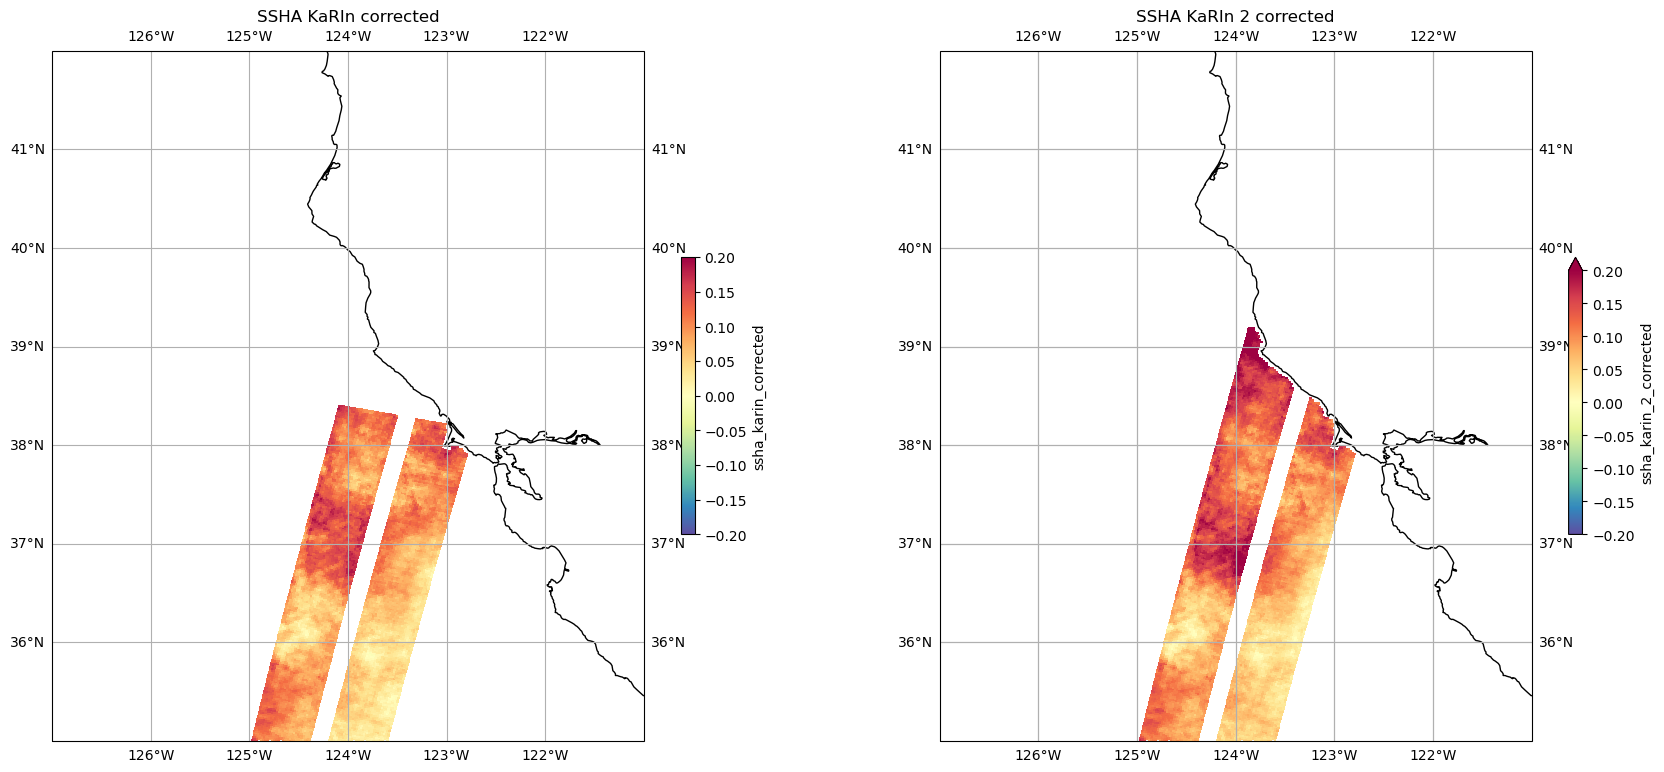

In [18]:
# set figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 12), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax1.set_extent(localbox)
ax2.set_extent(localbox)
plot_kwargs = dict(
    x="longitude",
    y="latitude",
    cmap="Spectral_r",
    vmin=-0.2,
    vmax=0.2,
    cbar_kwargs={"shrink": 0.3},)

# SWOT KaRIn SLA plots
ds_basic_sub.ssha_karin_corrected.plot.pcolormesh(ax=ax1, **plot_kwargs)
ds_basic_sub.ssha_karin_2_corrected.plot.pcolormesh(ax=ax2, **plot_kwargs)
#
ax1.gridlines(draw_labels=True)
ax1.coastlines()
ax2.gridlines(draw_labels=True)
ax1.set_title("SSHA KaRIn corrected")
ax2.coastlines()
ax2.gridlines()
ax2.set_title("SSHA KaRIn 2 corrected")